### Neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation.

Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

In [1]:
import numpy as np
import gymnasium as gym
from sklearn.neural_network import MLPRegressor
import pickle
import matplotlib.pyplot as plt

# Suppress the 'ConvergenceWarning' generated by 'sklearn' when the optimizer hasn't converged due to the maximum number of iterations being set to 500.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Step 1:

In [2]:
def mixed_policy(observation, p = 0.5):
    # With probability p, choose a random action. Otherwise, choose action based on the pole's angle.
    if np.random.rand() < p:
        return np.random.choice([0, 1])
    else:
        return 0 if observation[2] < 0 else 1

In [3]:
env = gym.make('CartPole-v1')

episodes = 100

observations = []
actions = []
rewards = []
dones = []
next_observations = []

for i in range(episodes):

    done = 0
    obs = env.reset()[0]

    while not done:

        observations.append(obs)

        # Determine action using the mixed policy.
        act = mixed_policy(obs)
        actions.append(act)

        # Perform the action in the environment.
        obs, rew, done, _, _ = env.step(act)
        
        next_observations.append(obs)
        rewards.append(rew)
        dones.append(done)

env.close()

observations = np.array(observations)
actions = np.array(actions)

## Step 2:

In [4]:
# Compute the TD targets for learning the Q-function.
def compute_targets(Q_left, Q_right, observations, actions, rewards, next_observations, dones, gamma):
    targets = []
    for i in range(len(observations)):
        if dones[i]:
            # If the next state is terminal, the target is the immediate reward.
            target = rewards[i]
        else:
            # For non-terminal states, the target includes the reward and the discounted max future Q value.
            target = rewards[i] + gamma * np.max([Q_left.predict([next_observations[i]]), Q_right.predict([next_observations[i]])])
        targets.append(target)
    return targets

In [5]:
gammas = [0.95, 0.99, 1] # Discount factors
iterations = 20

# Dictionaries to store the Q-functions for each gamma over iterations.
Q_left_saves = {}
Q_right_saves = {}

for gamma in gammas:

    Q_left_saves[gamma] = []
    Q_right_saves[gamma] = []

    # Initial target values are zero.
    targets = np.zeros(len(observations))

    # Initialize the Q-functions for both actions.
    Q_left = MLPRegressor(max_iter = 500).fit(observations[actions == 0], targets[actions == 0])
    Q_right = MLPRegressor(max_iter = 500).fit(observations[actions == 1], targets[actions == 1])

    for _ in range(iterations):

        # Compute new targets.
        targets = compute_targets(Q_left, Q_right, observations, actions, rewards, next_observations, dones, gamma)
        targets = np.array(targets)

        # Update the Q-functions based on new targets.
        Q_left = MLPRegressor(max_iter = 500).fit(observations[actions == 0], targets[actions == 0])
        Q_right = MLPRegressor(max_iter = 500).fit(observations[actions == 1], targets[actions == 1])

        # Save the updated Q-functions.
        Q_left_saves[gamma].append(Q_left)
        Q_right_saves[gamma].append(Q_right)

In [6]:
# Save the Q-functions to disk for later use.
with open('q_saves.pkl', 'wb') as f:
    pickle.dump([Q_left_saves, Q_right_saves], f)

In [7]:
# Load the Q-functions from disk.
with open('q_saves.pkl', 'rb') as f:
    Q_left_saves, Q_right_saves = pickle.load(f)

## Step 3:

In [8]:
# Decide on an action based on the Q-function estimates for the current observation.
def action_decision(Q_left, Q_right, obs):
    if Q_left.predict([obs]) > Q_right.predict([obs]):
        return 0
    else:
        return 1

In [13]:
episodes = 1000

env = gym.make('CartPole-v1')

# Dictionary to store the mean rewards for each gamma.
MC_rewards = {}

for gamma in gammas:

    MC_rewards[gamma] = []

    for i in range(len(Q_left_saves[gamma])):

        reward = []

        for _ in range(episodes):

            accumulated_reward = 0
            done = 0

            obs = env.reset()[0]

            while not done and accumulated_reward < 500:

                # Use the saved Q-functions to decide on actions.
                Q_left = Q_left_saves[gamma][i]
                Q_right = Q_right_saves[gamma][i]
                action = action_decision(Q_left, Q_right, obs)
                
                obs, rew, done, _, _ = env.step(action)
                accumulated_reward += rew

            reward.append(accumulated_reward)

        # Compute the mean reward across episodes
        mean_reward = sum(reward)/episodes
        MC_rewards[gamma].append(mean_reward)

env.close()

In [17]:
# Save the mean rewards to disk for later use.
with open('mc_rewards.pkl', 'wb') as f:
    pickle.dump(MC_rewards, f)

In [18]:
# Load the mean rewards from disk.
with open('mc_rewards.pkl', 'rb') as f:
    MC_rewards = pickle.load(f)

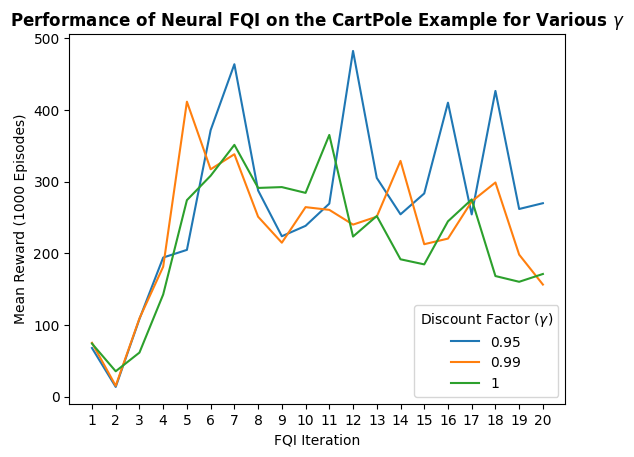

In [19]:
# Create a plot to visualize the performance of policies across different gammas and iterations.
fig, ax = plt.subplots()
for key, values in MC_rewards.items():
    ax.plot(range(1, len(values) + 1), values, label = key)

ax.set_xlabel('FQI Iteration')
ax.set_xticks(range(1, len(values)+1))
ax.set_ylabel('Mean Reward (1000 Episodes)')
ax.set_title('Performance of Neural FQI on the CartPole Example for Various $\gamma$', fontweight='bold')
ax.legend(title = 'Discount Factor ($\gamma$)')

plt.savefig('neural_fqi_cartpole_performance.png', dpi=300)
plt.show()

The initial increase in performance during the first few iterations is an expected outcome as the algorithm begins to learn from the offline data. However, the consistent failure to converge within the 500 iterations limit suggests that the model might be struggling to stabilize its learning. This could be due to a variety of factors, such as the complexity of the neural network, the need for more data, or excessive variability in Q-value estimations from one iteration to the next, which prevents convergence. The chosen limit of 500 iterations for fitting the neural networks at each FQI iteration may be insufficient, as evidenced by the frequent convergence warnings after the initial iterations. Increasing this limit may allow the performance to continue improving beyond the point where it currently plateaus.

Capping Monte Carlo simulations at a reward of 500 due to computational constraints will certainly influence the mean rewards reported. This limit may skew the results by not fully reflecting the true quality of the policy and can also obscure the potential differences between policies, especially if some could achieve higher rewards without the cap.

The observation that lower discount factors potentially yield better performance is consistent with the intuition that placing too much value on uncertain future rewards can be problematic. Discount factors close to 1 increase the emphasis on long-term rewards, which, in a task like CartPole where immediate action is crucial, may not be advantageous. In contrast, policies with a higher discount rate (lower γ) prioritize immediate rewards, which tend to be more predictable and stable, thus potentially leading to improved performance for this particular task. However, it is challenging to ascertain the true extent to which this trend in the performance of different discount factors holds, given the previously stated limitations.